# Playing with concurrency
## A short story about `concurrent.futures`

In [1]:
import concurrent.futures
import matplotlib.pyplot as plt
import numpy as np
import time
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor
%matplotlib inline

Let's write some functions that do stuff (a more IRL-based use case later on).

In [111]:
def n_fibonacci(n=10):
    """Calculate the Nth Fibonacci number"""
    i = 0
    x = 1
#     print(x)
    for __ in range(n):
        x, i = x + i, x
#         print(x)
    return x

def fake_write(whatevs=None):
    """Take some time as if it were writing to disk/calling a rest API"""
#     long_time = np.random.randint(1,5)
    long_time = 1. + np.random.random()
    time.sleep(long_time)
    return "Done with {} after {} secs".format(whatevs, long_time)

def calc_length(x):
    """Typically x is an int"""
    return len(str(x))

def calc_lengths(iterable_object):
    """Generate lenghts of values from generator.
    
    Works for any iterable.
    """
    for x in iterable_object:
        yield calc_length(x)

def print_stuff(generator_object):
    """Print values as they are generated"""
    for x in generator_object:
        print(x)

In [61]:
%time x = n_fibonacci(500000)
len(str(x))

CPU times: user 3.28 s, sys: 0 ns, total: 3.28 s
Wall time: 3.28 s


104494

Let's create an array of integers to act as input for our functions:

In [30]:
randints = 500000 + np.random.randint(1, 10, 8)
randints

array([500008, 500003, 500002, 500001, 500005, 500006, 500002, 500007])

How long does it take to process the whole array?

In [68]:
%%time
results = (
    n_fibonacci(n) for n in randints
)
print_stuff(calc_lengths(results))

104496
104495
104495
104494
104495
104495
104495
104496
CPU times: user 26.9 s, sys: 8 ms, total: 26.9 s
Wall time: 26.9 s


In [71]:
%%time
results = map(
    n_fibonacci, randints
)
print_stuff(calc_lengths(results))

104496
104495
104495
104494
104495
104495
104495
104496
CPU times: user 27.1 s, sys: 8 ms, total: 27.1 s
Wall time: 27.1 s


This is definitely too long... how can one improve it?

### Multiprocessing through `concurrent.futures`

In [81]:
%%time
with ProcessPoolExecutor() as p_executor:
    results = p_executor.map(n_fibonacci, randints)
#     printout = p_executor.map(calc_length, results)
#     print(list(printout))
    print_stuff(calc_lengths(results))

104496
104495
104495
104494
104495
104495
104495
104496
CPU times: user 1.48 s, sys: 32 ms, total: 1.52 s
Wall time: 13.6 s


This is better, but shouldn't it be `n_procs` better?  
Let's take a deeper look:

In [70]:
start = time.time()
with ProcessPoolExecutor() as p_executor:
    checkpoint_a = time.time()
    results = p_executor.map(n_fibonacci, randints, chunksize=2)
    print_stuff(calc_lengths(results))
    checkpoint_b = time.time()
end = time.time()
print("Pool setup time: {} secs".format(checkpoint_a - start))
print("Computation time: {} secs".format(checkpoint_b - checkpoint_a))
print("Teardown time: {} secs".format(end - checkpoint_b))

104496
104495
104495
104494
104495
104495
104495
104496
Pool setup time: 0.001384735107421875 secs
Computation time: 13.761390924453735 secs
Teardown time: 0.00434112548828125 secs


There is minimal overhead for setting up the pool of processes (about 1 ms).  
Most overhead is due to communication between processes (i.e. sending around data).

One can analyse how this evolves with the length of the single task.

In [198]:
plot_data = []
with ProcessPoolExecutor() as p_executor:
    for i in range(1, 6):
        print(i)
        randints = i * 50000 + np.random.randint(1, 10, 32)
        start = time.time()
        results = (
            n_fibonacci(n) for n in randints
        )
#         print_stuff(calc_lengths(results))
        [__ for __ in results]
        seq_time = time.time() - start
        start = time.time()
        results = p_executor.map(n_fibonacci, randints)
        [__ for __ in results]
        plot_data.append((i, seq_time, time.time() - start))
print(plot_data)
# plt.plot(*plot_data);

1
2
3
4
5
[(1, 1.2469956874847412, 0.8144452571868896), (2, 4.454180955886841, 2.829066276550293), (3, 10.362726211547852, 4.764616966247559), (4, 16.899455070495605, 8.826596021652222), (5, 34.47688412666321, 20.414557695388794)]


In [196]:
two_procs_data = []
with ProcessPoolExecutor(2) as p_executor:
    for i in range(1, 6):
        print(i)
        randints = i * 50000 + np.random.randint(1, 10, 32)
        start = time.time()
        results = p_executor.map(n_fibonacci, randints, chunksize=16)
        [__ for __ in results]
        two_procs_data.append((i, time.time() - start))

1
2
3
4
5


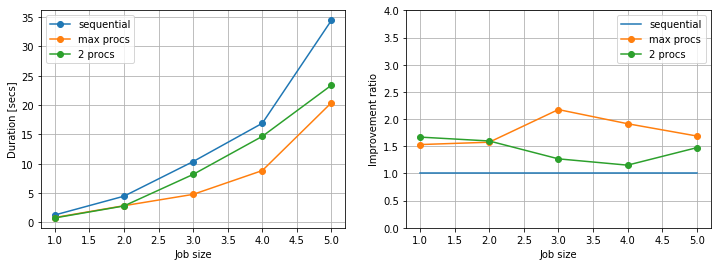

In [199]:
plt.figure(figsize=(12, 4))
x = [x[0] for x in plot_data]
y_seq = [x[1] for x in plot_data]
y_para = [x[2] for x in plot_data]
y_ratio = [x[1]/x[2] for x in plot_data]
y_para_two = [x[1] for x in two_procs_data]
y_ratio_two = [x[0][1]/x[1][-1] for x in zip(plot_data, two_procs_data)]
plt.subplot(1, 2, 1)
plt.xlabel("Job size")
plt.ylabel("Duration [secs]")
plt.plot(x, y_seq, '-o', label="sequential")
plt.plot(x, y_para, '-o', label="max procs")
plt.plot(x, y_para_two, '-o', label="2 procs")
# plt.yscale('log')
plt.legend()
plt.grid();
plt.subplot(1, 2, 2)
plt.xlabel("Job size")
plt.ylabel("Improvement ratio")
plt.plot(x, np.ones(len(x)), label="sequential")
plt.plot(x, y_ratio, '-o', label="max procs")
plt.plot(x, y_ratio_two, '-o', label="2 procs")
plt.ylim((0,4))
plt.legend()
plt.grid();

In [200]:
y_ratio_two

[1.6685544039351539,
 1.5972164668085926,
 1.2684957314910479,
 1.1523228763366664,
 1.4735822384582045]

### Now what?

We have calculated important stuff, and we want to store it/send it somewhere safe.

Let's say we save it to disk for now.
How long is that going to take?

In [201]:
randints = 3 * 100000 + np.random.randint(1, 10, 32)

In [202]:
%%time
with ProcessPoolExecutor() as p_exec:
    results = p_exec.map(n_fibonacci, randints)
    myres = list(results)

CPU times: user 44 ms, sys: 44 ms, total: 88 ms
Wall time: 23.5 s


In [203]:
%%time
for r in myres:
    fake_write(r)

CPU times: user 3.19 s, sys: 4 ms, total: 3.2 s
Wall time: 49.8 s


In [204]:
%%time
with ProcessPoolExecutor() as p:
    results = p.map(fake_write, myres)
    print_stuff(calc_lengths(results))

62738
62738
62738
62738
62738
62738
62737
62737
62738
62737
62738
62737
62738
62738
62737
62739
62737
62737
62738
62738
62737
62737
62736
62737
62738
62737
62737
62737
62738
62738
62738
62738
CPU times: user 56 ms, sys: 52 ms, total: 108 ms
Wall time: 12.4 s


In [205]:
%%time
with ThreadPoolExecutor() as p:
    results = p.map(fake_write, myres)
    print_stuff(calc_lengths(results))

62738
62738
62738
62738
62738
62737
62737
62737
62737
62737
62738
62737
62738
62738
62737
62739
62736
62737
62738
62738
62738
62738
62737
62738
62738
62736
62736
62737
62738
62738
62738
62737
CPU times: user 2.33 s, sys: 28 ms, total: 2.36 s
Wall time: 4.23 s


How does it actually scale?

In [206]:
data = []
for i in range(1, 6):
    print(i)
    n_exec = i*5
    with ThreadPoolExecutor(n_exec) as p:
        start = time.time()
        results = p.map(fake_write, myres)
        list(calc_lengths(results))
        data.append((n_exec, time.time() - start))

1
2
3
4
5


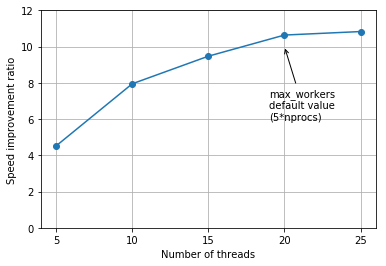

In [240]:
x = [x[0] for x in data]
y = [50/x[1] for x in data]
plt.plot(x, y, '-o')
plt.ylim((0,12))
plt.xticks(x)
plt.xlabel("Number of threads")
plt.ylabel("Speed improvement ratio")
# plt.arrow(20, 6, 0, 3)
plt.annotate("max_workers\ndefault value\n(5*nprocs)", xy=(20, 10), xytext=(19,6), arrowprops=dict(arrowstyle="->"))
plt.grid();

### Combining everything together
Can we use these tools to optimize all parts of a program?

In [239]:
%%time
randints = 3 * 100000 + np.random.randint(1, 10, 32)
with ProcessPoolExecutor() as pp:
    with ThreadPoolExecutor() as tp:
        cpu_results = pp.map(n_fibonacci, randints)
        cpu_results = pp.map(calc_length, cpu_results)
        th_results = tp.map(fake_write, cpu_results)
        print_stuff(th_results)

Done with 62698 after 1.8452377977607 secs
Done with 62697 after 1.6004247781622287 secs
Done with 62697 after 1.203338716751865 secs
Done with 62699 after 1.8320660043625843 secs
Done with 62698 after 1.541215860755574 secs
Done with 62698 after 1.4487164685602867 secs
Done with 62697 after 1.1292529012244903 secs
Done with 62697 after 1.0192214898392111 secs
Done with 62697 after 1.866542201382015 secs
Done with 62698 after 1.6618804741297568 secs
Done with 62698 after 1.8996933546168333 secs
Done with 62699 after 1.9702075183281091 secs
Done with 62698 after 1.1879410037802896 secs
Done with 62697 after 1.6444882109009045 secs
Done with 62697 after 1.9633717302751834 secs
Done with 62698 after 1.8655745657537375 secs
Done with 62698 after 1.1315758358365882 secs
Done with 62698 after 1.3001334300359186 secs
Done with 62698 after 1.3468844638252766 secs
Done with 62697 after 1.6397316229913952 secs
Done with 62698 after 1.611739761182685 secs
Done with 62697 after 1.9841667425718934 

In [242]:
%%time
randints = 3 * 100000 + np.random.randint(1, 10, 32)
with ProcessPoolExecutor() as pp:
    with ThreadPoolExecutor() as tp:
        cpu_results = pp.map(n_fibonacci, randints)
        p_futures = []
        t_futures = []
        for res in cpu_results:
            p_futures.append(
                pp.submit(calc_length, res)
            )
        for f in concurrent.futures.as_completed(p_futures):
            t_futures.append(
                tp.submit(fake_write, f.result())
            )
#         for res in cpu_results:
#             mylen = calc_length(res)
#             tp.submit(fake_write, mylen)
        for f in concurrent.futures.as_completed(t_futures):
            print(f.result())

Done with 62697 after 1.036890392462696 secs
Done with 62697 after 1.154880673407481 secs
Done with 62698 after 1.120797452488131 secs
Done with 62697 after 1.4297922044590643 secs
Done with 62699 after 1.6007876548554716 secs
Done with 62697 after 1.596233916904156 secs
Done with 62697 after 1.6777425859323443 secs
Done with 62698 after 1.4201978820832304 secs
Done with 62698 after 1.4847861741549266 secs
Done with 62698 after 1.8312847920892972 secs
Done with 62698 after 1.7061179740433472 secs
Done with 62698 after 1.5232140669155514 secs
Done with 62697 after 1.6861718799963124 secs
Done with 62697 after 1.8764649649340386 secs
Done with 62698 after 1.8458969674697707 secs
Done with 62698 after 1.8544265022668798 secs
Done with 62698 after 1.7617868712702787 secs
Done with 62697 after 1.8992451477036085 secs
Done with 62697 after 1.7954095081054957 secs
Done with 62698 after 1.9688913392691483 secs
Done with 62697 after 1.4481571477575699 secs
Done with 62698 after 1.53421240964305

### Quick code analysis

This piece of code has two main parts (does it look familiar?):

1. A computing part.
2. An I/O part.

Let's take a look at each one separately.

### Using map

In [97]:
%%time
with ProcessPoolExecutor() as p_executor:
    with ThreadPoolExecutor() as executor:
        results = p_executor.map(n_fibonacci, randints)
        results = executor.map(fake_write, results)
        print(list(results)[:3])

[None, None, None]
CPU times: user 60 ms, sys: 24 ms, total: 84 ms
Wall time: 24.3 s


### Using submit

In [99]:
%%time
with ProcessPoolExecutor() as p_executor:
    with ThreadPoolExecutor() as executor:
        futures = [
            p_executor.submit(n_fibonacci, randn) for randn in randints
        ]
        t_futures = [
            executor.submit(
                fake_write,
                future.result()
            ) for future in concurrent.futures.as_completed(futures)
        ]
        concurrent.futures.wait(t_futures)

CPU times: user 60 ms, sys: 28 ms, total: 88 ms
Wall time: 28.7 s


## Improvements

### Chunksize

In [59]:
%%time
with ProcessPoolExecutor() as p_executor:
    with ThreadPoolExecutor() as executor:
        results = p_executor.map(n_fibonacci, randints, chunksize=32)
        executor.map(fake_write, results)

CPU times: user 44 ms, sys: 24 ms, total: 68 ms
Wall time: 24.1 s
